Now we create a function which masks the last two words of the disease name (both words if there are only two)
We will present this to the LLM and ask it to give use the masked words.
Two correct words will count as a 'known entity', two incorrect words will count as an 'unknown entity'.
Inbetween will count as a 'half-known entity' nd be dismissed form the analysis, as per Ferrando et al.

In [2]:
import goodfire
import os
import re
import pandas as pd
import json
from nltk import WordNetLemmatizer
from difflib import SequenceMatcher
import nest_asyncio
import asyncio
from tqdm import tqdm
from together import Together
import time
import logging
from datetime import datetime
from typing import List, Dict, Tuple
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from tqdm.notebook import tqdm


In [3]:

api_key ='REDACTED'
client = goodfire.Client(api_key)
TOGETHER_API_KEY = 'REDACTED'
variant = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
os.environ["OPENAI_API_KEY"] = "REDACTED"


## Beware the Contrastive Trick

In the contrastive trick we subtract the feature activiations of a 'known' entity from the feature activations of an unknown entity. We can sum or average the differences over a batch of such pairs, getting the most different features between each set. Negative features are those which indicate hallucination, positive features indicate non-hallucination.We can repeat this batched process over the entire data set and union the resulting features from each batch into a single distinct list of feature differences.

BUT

As per Ferrando et al, we want the features which are activated almost exclusively in one condition (known vs. unknown) but rarely or  never activate in the other condition. We are interested in exclusivity not scale.

Simply summing the per-batch differences in activations is not well-suited to detecting exclusive features. Summation over subsets will highlight features that have large aggregate differences. This will include the exclusive features we seek, but will not isolate them. We wont know which if the differing features are alsmost exclusive to one class or other.

So

We follow the approach by Ferrando et al, see p4 of 'Do I know this entity?': 

```
For each latent, we obtain the fraction of the time that it is active (i.e. has a value greater than zero) on known and unknown entities respectively...Then, we take the difference, obtaining the latent separation scores
```

In order to achieve this, we need to get the activated features from each and every prompt, we can't use the contrastive trick as per above.

##  Chosen Datasets!

'The Human Disease Ontology' (HumanDO) which is freely available on the web and github:

https://disease-ontology.org/

https://github.com/DiseaseOntology/HumanDiseaseOntology/tree/main/src/ontology

From the github site we can download the HumanDO.json file. Example content below:


In [2]:
# Example from HumanDO.json
with open('../classifier/data_classifier/HumanDO.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    # If the JSON structure has a top-level key containing the graph data,
    # you might need to access it like data['graphs'] or similar
    humando = data.get('graphs', [{}])[0].get('nodes', [])

humando[0]

{'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
 'lbl': 'angiosarcoma',
 'type': 'CLASS',
 'meta': {'definition': {'val': 'A vascular cancer that derives_from the cells that line the walls of blood vessels or lymphatic vessels.',
   'xrefs': ['url:http://en.wikipedia.org/wiki/Hemangiosarcoma',
    'url:https://en.wikipedia.org/wiki/Angiosarcoma',
    'url:https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI_Thesaurus&ns=ncit&code=C3088',
    'url:https://www.ncbi.nlm.nih.gov/pubmed/23327728']},
  'subsets': ['http://purl.obolibrary.org/obo/doid#DO_cancer_slim',
   'http://purl.obolibrary.org/obo/doid#NCIthesaurus'],
  'synonyms': [{'pred': 'hasExactSynonym', 'val': 'hemangiosarcoma'}],
  'xrefs': [{'val': 'ICDO:9120/3'},
   {'val': 'MESH:D006394'},
   {'val': 'NCI:C3088'},
   {'val': 'NCI:C9275'},
   {'val': 'SNOMEDCT_US_2023_03_01:39000009'},
   {'val': 'UMLS_CUI:C0018923'},
   {'val': 'UMLS_CUI:C0854893'}],
  'basicPropertyValues': [{'pred': 'http://www.geneont

## Helper Functions

In [3]:
def score_llm_response(llm_response, expected_words, missing_qty=2):
    """
    Score LLM response against expected words using flexible matching rules.
    
    Args:
        llm_response (str): String containing one or two words in any format
        expected_words (list): List of expected words (one or two)
        missing_qty (int): Number of words expected (1 or 2)
        
    Returns:
        int: Score (0, 1, or 2 for missing_qty=2; 0 or 1 for missing_qty=1) based on number of correct matches
    """
    def clean_word(word):
        """Convert to singular form and lowercase"""
        lemmatizer = WordNetLemmatizer()
        
        word = word.lower().strip()
        word = word.strip('"\'[](),.')  # Remove common punctuation
        
        word = lemmatizer.lemmatize(word, 'n')
        return word
    
    def words_match(word1, word2):
        """Check if words approximately match using sequence matcher"""
        word1 = clean_word(word1)
        word2 = clean_word(word2)
        
        ratio = SequenceMatcher(None, word1, word2).ratio()
        return ratio > 0.85  # Threshold for approximate matching
    
    def extract_words(llm_response, missing_qty):
        """Extract first two words from first sequence in various input formats"""
        # Split on common sequence separators like 'or', 'and', newlines
        sequences = re.split(r'\s+or\s+|\s+and\s+|\n', llm_response, flags=re.IGNORECASE)
        
        # Take only the first sequence
        first_sequence = sequences[0]
        
        # Remove any brackets, quotes, etc.
        first_sequence = re.sub(r'[\[\]\'"{},]', ' ', first_sequence)
        
        # Split on whitespace and filter out empty strings
        words = [word.strip() for word in first_sequence.split() if word.strip()]
        
        # Take first two non-empty words
        return words[:missing_qty]
    
    try:
        # if simply answering questions missing_qty is -1, but we mean '1'.
        if missing_qty == -1:
            missing_qty = 1

        # Validate missing_qty parameter
        if missing_qty not in [-1, 1, 2]:
            raise ValueError("missing_qty must be either 1 or 2")
            
        # Validate expected_words length matches missing_qty
        if len(expected_words) != missing_qty:
            raise ValueError(f"Expected {missing_qty} words but got {len(expected_words)} words")
        
        # Extract words from response string
        llm_words = extract_words(llm_response, missing_qty)
        
        if len(llm_words) < missing_qty:
            return 0  # Not enough words provided
            
        # Count matches (allowing for either order)
        matches = 0
        used_expected = set()
        used_llm = set()
        
        # Look for matches in any order
        for i, llm_word in enumerate(llm_words):
            for j, expected_word in enumerate(expected_words):
                if j not in used_expected and i not in used_llm:
                    if words_match(llm_word, expected_word):
                        matches += 1
                        used_expected.add(j)
                        used_llm.add(i)
                        break
        
        return matches
        
    except Exception as e:
        print(f"Error processing response: {e}")
        return 0


In [4]:

from tqdm import tqdm
from together import Together
import time

def query_to_llm_(records, provider="goodfire", missing_qty = 2):
    
    # Get data
    records_completed = []
    client_gf = goodfire.Client(api_key)
    client_tg = Together(api_key=TOGETHER_API_KEY)

    # loop over the data with tqdm progress bar
    for record in tqdm(records, desc="Processing records"):
    
        # Create query with instructions to LLM
        if missing_qty == 2:
            instruction = "Without preamble, give the two missing words as indicated by [Word A] and [Word B] in the following sentence. Return your answer as a python list:\n "
        elif missing_qty == 1:
            instruction = "Without preamble, give the missing word as indicated by [Word A] in the following sentence. Return your answer as a python list:\n "
        elif missing_qty == -1:
            instruction = "Without preamble, give the answer to the following question. Return your answer as a member of a python list:\n "

        else:
            print("No such quantity of missing words")
            return
            
        query = instruction + record['query']

        if provider == 'goodfire':
            
            # Simple rate limiting
            time.sleep(1.5)

            # Create a non-streaming completion using Goodfire
            response = client_gf.chat.completions.create(
                messages=[{"role": "user", "content": query}],
                model="meta-llama/Meta-Llama-3.1-8B-Instruct", # "meta-llama/Llama-3.3-70B-Instruct", "meta-llama/Meta-Llama-3.1-8B-Instruct"
            )
            llm_response = response.choices[0].message["content"]

        else:
            # call Together.ai

            try:
                response = client_tg.chat.completions.create(
                    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
                    messages=[{"role": "user", "content": query}],
                    temperature=0.0,
                )
                llm_response = response.choices[0].message.content

            except Exception as e:
                llm_response = ''
                print(e)

        # Score LLM response
        score = score_llm_response(llm_response, expected_words=record['missing_words'], missing_qty=missing_qty)

        # Save results
        record['llm_response'] = llm_response
        record['score'] = score
        records_completed.append(record)

    return records_completed


In [5]:
# Enable nested event loops
nest_asyncio.apply()

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'async_performance_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('query_processor')

class AsyncRateLimiter:
    """Async rate limiter using a semaphore and sliding window"""
    def __init__(self, rate_limit=100):
        self.semaphore = asyncio.Semaphore(rate_limit)
        self.request_times = []
        self.window_size = 60  # 1 minute window
        self.requests_per_minute = rate_limit
        self.lock = asyncio.Lock()
        self.logger = logging.getLogger('query_processor.rate_limiter')

    async def acquire(self):
        """Acquire rate limit token"""
        start_time = time.time()
        current_time = start_time
        
        async with self.lock:
            # Remove timestamps older than our window
            self.request_times = [t for t in self.request_times 
                                if current_time - t < self.window_size]
            
            # If we're at capacity, wait until we have room
            while len(self.request_times) >= self.requests_per_minute:
                wait_time = self.request_times[0] + self.window_size - current_time
                if wait_time > 0:
                    await asyncio.sleep(wait_time)
                current_time = time.time()
                self.request_times = [t for t in self.request_times 
                                    if current_time - t < self.window_size]
            
            self.request_times.append(current_time)
            await self.semaphore.acquire()

    async def release(self):
        """Release rate limit token"""
        self.semaphore.release()

async def query_goodfire(client, query, rate_limiter):
    """Make a rate-limited query to Goodfire with retries"""
    max_retries = 5
    initial_wait = 1
    
    for retry in range(max_retries):
        try:
            await rate_limiter.acquire()
            try:
                response = await client.chat.completions.create(
                    messages=[{"role": "user", "content": query}],
                    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
                    temperature=0
                )
                return response.choices[0].message['content']
            finally:
                await rate_limiter.release()
        except Exception as e:
            if retry == max_retries - 1:
                logger.error(f"Max retries exceeded: {str(e)}")
                return ''
            wait_time = initial_wait * (2 ** retry)
            await asyncio.sleep(wait_time)
    
    return ''

async def process_record(record, client_gf, client_tg, rate_limiter, provider, missing_qty):
    """Process a single record"""
    # Create query with instructions
    if missing_qty == 2:
        instruction = "Without preamble, give the two missing words as indicated by [Word A] and [Word B] in the following sentence. Return your answer as a python list:\n "
    elif missing_qty == 1:
        instruction = "Without preamble, give the missing word as indicated by [Word A] in the following sentence. Return your answer as a python list:\n "
    elif missing_qty == -1:
        instruction = "Without preamble, give the answer to the following question. Return your answer as a member of a python list:\n "

    else:
        return None
        
    query = instruction + record['query']

    if provider == 'goodfire':
        llm_response = await query_goodfire(client_gf, query, rate_limiter)
    else:
        try:
            response = client_tg.chat.completions.create(
                model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
                messages=[{"role": "user", "content": query}],
                temperature=0.0,
            )
            llm_response = response.choices[0].message.content
        except Exception as e:
            logger.error(f"Together API error: {str(e)}")
            llm_response = ''

    # Score LLM response
    score = score_llm_response(llm_response, expected_words=record['missing_words'], missing_qty=missing_qty)

    return {
        **record,
        'llm_response': llm_response,
        'score': score
    }

async def query_to_llm_async(ds_ncbi_processed, provider, missing_qty):
    """Asynchronous version of query_to_llm with robust rate limiting"""
    # Initialize clients and rate limiter
    client_gf = goodfire.AsyncClient(api_key)
    client_tg = Together(api_key=TOGETHER_API_KEY)
    rate_limiter = AsyncRateLimiter(rate_limit=40)  # Conservative rate limit
    
    # Process records concurrently
    tasks = [
        process_record(record, client_gf, client_tg, rate_limiter, provider, missing_qty)
        for record in ds_ncbi_processed
    ]
    
    ds_ncbi_completed = []
    for coro in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="Processing records"):
        result = await coro
        if result:
            ds_ncbi_completed.append(result)
    
    return ds_ncbi_completed

def query_to_llm(ds_ncbi_processed, provider="goodfire", missing_qty=-1):
    """Synchronous wrapper for the async implementation"""
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(query_to_llm_async(ds_ncbi_processed, provider, missing_qty))

In [32]:

def get_feature_activations(client, variant, entity_names, k=50):
    """
    Simple synchronous version that processes one example at a time
    """
    feature_activations = []
    feature_library = set()



    for entity_name in tqdm(entity_names, desc="Processing entity_names"):
        try:
            inspector = client.features.inspect(
                [{"role": "user", "content": entity_name}],
                model=variant,
                #features=features
            )

            #  prepare to collect activated features
            entity_features=[]

            for activation in inspector.top(k=k):

                # keep our own library of all unique features and their id's
                feature_library.add((activation.feature.uuid, activation.feature.label))

                # record the feature id and its activation value for this entity 
                entity_features.append({'uuid':activation.feature.uuid, 'activation':activation.activation})

            feature_activations.append({'entity_name': entity_name, 'entity_features': entity_features})
            time.sleep(0.25)  # Simple rate limiting

        except Exception as e:
            print(f"Failed to process example: {str(e)}")
            continue
            
    return feature_activations, feature_library



In [33]:

# Fucntion to help select the unique known and unknown entities

def filter_duplicate_entities(known_list, unknown_list):
    # Create sets of entity names from both lists
    known_names = {record['entity_name'] for record in known_list}
    unknown_names = {record['entity_name'] for record in unknown_list}
    
    # Find duplicate names that appear in both lists
    duplicate_names = known_names.intersection(unknown_names)
    
    # Filter out records with duplicate names from both lists
    filtered_known = [record for record in known_list 
                     if record['entity_name'] not in duplicate_names]
    filtered_unknown = [record for record in unknown_list 
                       if record['entity_name'] not in duplicate_names]
    
    return filtered_known, filtered_unknown




In [34]:
# we need only 
# a) the disease label, which will our entity. 
#   - Some are long names with many words, we limit to disease entities with 2 words in their name.
# b) the meta definition, which will be used to generate questions and attributes.
# c) an id should we ever need to relate back to the original data

def parse_disease_entries(data, max_words=2):
    """
    Parse disease entries from Disease Ontology JSON format, filtering by word count in label.
    
    Args:
        data (list): List of disease entry dictionaries
        max_words (int, optional): Maximum number of words allowed in disease label. Defaults to 3.
        
    Returns:
        list: List of dictionaries containing parsed disease information with filtered labels
    """
    parsed_diseases = []
    
    for entry in data:
        label = entry.get('lbl', '')
        
        # Skip entries where label word count exceeds max_words
        if len(label.split()) > max_words:
            continue
            
        disease_info = {
            'entity': label,
            'description': '',
            'id': entry.get('id', '')
        }
        
        # Extract description from meta.definition if it exists
        meta = entry.get('meta', {})
        if 'definition' in meta:
            definition = meta['definition']
            if isinstance(definition, dict) and 'val' in definition:
                # Replace underscores with spaces in the description, as these appear annnoyingly common
                disease_info['description'] = definition['val'].replace('_', ' ')
        
        parsed_diseases.append(disease_info)
    
    return parsed_diseases

Process the records and then spit into train and test.

## Anlayse Data for Features - Known vs Unknown

We now need to see how well the LLM performs on the query, will it get fill in the blanks correctly?
Waht are the features separation scores on the known vs unknown entities?

Happily, we can use the functions we have already written on the Humand DO data.

1. Send each query to the LLM and score their knowledge o the disease entites
2. Use Goodfire to get the SAE features for the known vs unknown entities (not the queries, but the entities)
3. Calculate the separate scores for each feature on known vs unknown data

## Create New Questions Using HumanDO data

We need to do this precisely as per Ferrando et al.
So we need to ask an LLM to do the following, as per an example using HumanDO...
We will use GTP4-mini, as there will be thousands of questions, so many millions of tokens to process. 

```
Devise two questions with one word answers about this using this information only:
"The disease Primary hyperoxaluria is a carbohydrate metabolic disorder characterized by impaired glyoxylate metabolism resulting in accumulation of oxalate throughout the body typically manifesting as kidney and bladder stones.", 

Your questions must start with "The disease Primary hyperoxaluria ...".
Return your questions as a python list of dicts with the query and answer:
[{query:"The disease....", answer:"..."}{query:"The disease....", answer:"..."}]
```

In [12]:
# Inspect sample
import pandas as pd
humando_parsed = pd.read_parquet('../classifier/data_classifier/humando_parsed_2Q.parquet')
humando_parsed = humando_parsed.to_dict('records')
humando_parsed = [{'entity': d['entity'], 'description': d['description'], 'id': d['id']} for d in humando_parsed]
humando_parsed[0:3]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816'},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116'},
 {'entity': 'shrimp allergy',
  'description': 'A crustacean allergy that has allergic trigger shrimp.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0040001'}]

In [13]:

class QuestionAnswer(BaseModel):
    query: str = Field(..., description="The question about the disease")
    answer: str = Field(..., description="One-word answer to the question")

class QuestionGenerationAgent():
    """
    Agent responsible for generating questions and answers about diseases based on given descriptions.
    """
    async def run(self, llm, disease_records, red_herring=False):
        """
        Generate questions and answers based on the provided disease records.

        Args:
            llm: The language model to use for question generation
            disease_records (List[Dict]): List of disease records containing entity, description, and id

        Returns:
            tuple: A list of generated questions with answers and consumption details
        """
        try:
            tools = [{
                "name": "submit_questions",
                "description": "Submit generated questions and answers",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "question_answers": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "query": {"type": "string"},
                                    "answer": {"type": "string"}
                                },
                                "required": ["query", "answer"]
                            },
                            "description": "List of questions and their answers"
                        }
                    },
                    "required": ["question_answers"]
                }
            }]

            all_questions = []

            for record in disease_records:

                # Create the prompt with the specific disease information
                if red_herring:
                
                    messages = [
                        ("system", "You are a phoney medical question generator."),
                        ("user", """
                        TASK: You will be devising two questions about this disease: '{entity}'. 
                        BUT, you will intentionally misspell the disease or use a spoonersim in the disease name.
                        Each question will have an answer of only one word. 
                        You may ONLY use the following information to devise the question.
                        <disease_information_to_be_used>
                        The disease {entity} is {description}
                        </disease_information_to_be_used>

                        Instructions for formulating the Question:
                        - Each of the two questions MUST end with these words: "the disease {entity} ?". 
                        - BUT, you will intentionally misspell the disease or use a spoonersim in the disease name.

                        Instructions for formulating the Answer:
                        - Only one word per answer, no more.
                        - Ensure the answers are not ambiguous and are complete within the one or two words permitted.
                        - Return the two questions with their respective answers as per the tool 'submit_questions'.""")
                    ]
                else:
                    messages = [
                        ("system", "You are a medical question generator."),
                        ("user", """
                        TASK: You will be devising two questions about this disease: '{entity}'. 
                        Each question will have an answer of only one word 
                        You may ONLY use the following information to devise the question.
                        <disease_information_to_be_used>
                        The disease {entity} is {description}
                        </disease_information_to_be_used>

                        Instructions for formulating the Question:
                        - Each of the two questions MUST end with these words: "the disease {entity} ?". 
                        - To repeat, you must form the questions so that they end with those words.

                        Instructions for formulating the Answer:
                        - Only one word per answer, no more.
                        - Ensure the answers are not ambiguous and are complete within the one word permitted.
                        - Return the two questions with their respective answers as per the tool 'submit_questions'.""")
                    ]
                prompt = ChatPromptTemplate.from_messages(messages).partial()

                # Create and invoke the chain
                chain = (prompt | llm.bind_tools(tools, tool_choice="submit_questions"))
                response = await chain.ainvoke(record)

                # Extract and validate questions
                func_args = response.additional_kwargs['tool_calls'][0]['function']['arguments']
                func_args_data = json.loads(func_args)
                
                # Validate each question-answer pair using Pydantic
                for qa_pair in func_args_data['question_answers']:
                    validated_qa = QuestionAnswer(**qa_pair)
                    all_questions.append(validated_qa.model_dump())

            return all_questions

        except json.JSONDecodeError as e:
            msg = f"Question Generation Agent Error: Invalid JSON: {str(e)}"
            print(msg)
            raise

        except KeyError as e:
            msg = f"Question Generation Agent Error: Missing key in JSON: {str(e)}"
            print(msg)
            raise

        except Exception as e:
            msg = f"Question Generation Agent Error: Unexpected error: {str(e)}"
            print(msg)
            raise


In [14]:
async def process_records(records, agent, llm, red_herring, batch_size=10):
    """
    Process records in simple batches with progress tracking.
    
    Args:
        records: List of disease records
        agent: QuestionGenerationAgent instance
        llm: Language model instance
        batch_size: How many records to process at once
    """
    processed_records = []
    
    # Create batches
    total_batches = (len(records) + batch_size - 1) // batch_size
    
    print(f"Processing {len(records)} records in {total_batches} batches")
    start_time = datetime.now()
    
    # Process each batch
    for i in tqdm(range(0, len(records), batch_size), desc="Processing batches"):
        batch = records[i:i + batch_size]
        batch_tasks = []
        
        # Process each record
        for record in batch:
            try:
                question_answers = await agent.run(llm, [record], red_herring)
                # Ensure questions is treated as a list
                if not isinstance(question_answers, list):
                    print(f"Warning: questions for {record['id']} is not a list: {question_answers}")
                    question_answers_list = [question_answers] if question_answers else []
                else:
                    question_answers_list = question_answers
                
                # record whether this is a red herring or not.
                record['red_herring']=red_herring

                # if red_herring, change the id, else we get dupes
                if red_herring:
                    record['id'] = f"{record['id']}_rh"

                processed_records.append({**record, "question_answers": question_answers_list})
            except Exception as e:
                print(f"Error processing record {record['id']}: {str(e)}")
                processed_records.append({**record, "question_answers": [], "error": str(e)})
        
    # Print summary
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    print(f"\nProcessing completed in {duration:.2f} seconds")
    print(f"Successfully processed: {len(processed_records)} records")
    print(f"Average rate: {len(processed_records)/duration:.2f} records/second")
    
    return processed_records

In [55]:
import os

# Cell 1: Setup
from langchain_openai import ChatOpenAI

# Create the LLM instance
llm = ChatOpenAI(
    model="gpt-4o",  # or whatever model you're using
    temperature=0,
)

# Set up components
agent = QuestionGenerationAgent()

# Cell 2: Process records (use this code in a new cell)
# This works in Jupyter because it uses the notebook's event loop
# NOTE: red_herring tells us to create phoney entities or real ones.
humando_parsed_2Q = await process_records(humando_parsed, agent, llm, red_herring=False, batch_size=50)


Processing 4302 records in 87 batches


Processing batches:   0%|          | 0/87 [00:00<?, ?it/s]

2025-01-19 00:26:32,072 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 00:26:32,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 00:26:33,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 00:26:34,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 00:26:36,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 00:26:37,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 00:26:38,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 00:26:39,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 00:26:40,238 - httpx 


Processing completed in 4872.02 seconds
Successfully processed: 4302 records
Average rate: 0.88 records/second


In [56]:
import random
random.choices(humando_parsed_2Q, k=3)

[{'entity': 'IDH-wildtype glioblastoma',
  'description': 'A glioblastoma that is characterized by high cellularity, high mitotic activity, necrosis or microvascular proliferation and that lacks mutations in IDH genes.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0080878',
  'red_herring': False,
  'question_answers': [{'query': 'What type of cellularity characterizes the disease IDH-wildtype glioblastoma ?',
    'answer': 'High'},
   {'query': 'What type of activity is high in the disease IDH-wildtype glioblastoma ?',
    'answer': 'Mitotic'}]},
 {'entity': 'lip disease',
  'description': 'A mouth disease located in the lip.',
  'id': 'http://purl.obolibrary.org/obo/DOID_9297',
  'red_herring': False,
  'question_answers': [{'query': 'Where is the disease lip disease located in the body for the disease lip disease ?',
    'answer': 'lip'},
   {'query': 'What type of disease is the disease lip disease ?',
    'answer': 'mouth'}]},
 {'entity': 'osteomalacia',
  'description': 'A bone 

In [57]:
# get some red herrings
import math
agent = QuestionGenerationAgent()
humando_parsed_rd = random.choices(humando_parsed, k=200)
humando_parsed_2Q_rh = await process_records(humando_parsed_rd, agent, llm, red_herring=True, batch_size=50)

Processing 200 records in 4 batches


Processing batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-01-19 01:47:43,652 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 01:47:44,442 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 01:47:45,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 01:47:46,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 01:47:47,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 01:47:48,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 01:47:52,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 01:47:53,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-19 01:47:53,945 - httpx 


Processing completed in 239.13 seconds
Successfully processed: 200 records
Average rate: 0.84 records/second


In [58]:
# Add the two lists together
humando_parsed_2Q = humando_parsed_2Q + humando_parsed_2Q_rh

In [59]:
pd.DataFrame(humando_parsed_2Q).to_parquet('../classifier/data_classifier/humando_parsed_3Q.parquet')

#View an example
humando_parsed_2Q[1000]

{'entity': 'holoprosencephaly 5',
 'description': 'A holoprosencephaly that has material basis in heterozygous mutation in the ZIC2 gene on chromosome 13q32.',
 'id': 'http://purl.obolibrary.org/obo/DOID_0110878',
 'red_herring': False,
 'question_answers': [{'query': 'What gene mutation is associated with the disease holoprosencephaly 5 ?',
   'answer': 'ZIC2'},
  {'query': 'On which chromosome is the mutation found in the disease holoprosencephaly 5 ?',
   'answer': '13q32'}]}

In [15]:
# Pick up from saved data

humando_parsed_2Q = pd.read_parquet('../classifier/data_classifier/humando_parsed_3Q.parquet')
humando_parsed_2Q = humando_parsed_2Q.to_dict('records')
humando_parsed_2Q[0:4]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'red_herring': False,
  'question_answers': array([{'answer': 'Vascular', 'query': 'What type of cancer is the disease angiosarcoma ?'},
         {'answer': 'Lining', 'query': 'From which cells does the disease angiosarcoma derive ?'}],
        dtype=object)},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116',
  'red_herring': False,
  'question_answers': array([{'answer': 'corneal', 'query': 'What type of disease is the disease pterygium ?'},
         {'answer': 'triangular', 'query': 'What type of tissue growth characterizes the disease pterygium ?'}],
    

In [16]:
def convert_format(record):
    """
    Convert records to the format required by previous functions.
    
    Args:
        record (dict): Input record with question_answers field
        
    Returns:
        list: List of transformed records
    """
    # Create base record without question_answers
    base_record = {
        'entity': record['entity'],
        'description': record['description'],
        'id': record['id'],
        'red_herring': record['red_herring']
    }
    
    # Create a new record for each question-answer pair
    transformed_records = []
    for qa in record['question_answers']:
        new_record = base_record.copy()
        new_record['query'] = qa['query']
        new_record['missing_words'] = [qa['answer']]
        transformed_records.append(new_record)
    
    return transformed_records

In [17]:
humando_parsed_1Q = []
for record in humando_parsed_2Q:
    humando_parsed_1Q.extend(convert_format(record))

In [18]:
# inspect sample
# we expect two queries, i.e. two records, per id.
# We expect the missing word, [Word A], to be the last word in all queries, i.e. the answer.
humando_parsed_1Q[0:4]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'red_herring': False,
  'query': 'What type of cancer is the disease angiosarcoma ?',
  'missing_words': ['Vascular']},
 {'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'red_herring': False,
  'query': 'From which cells does the disease angiosarcoma derive ?',
  'missing_words': ['Lining']},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116',
  'red_herring': False,
  'query': 'What type of disease is 

Now the data is in the same format as previously we can use same functions.
We will have twice as many records to process, so 8000+ calls to Goodfire.
Let's process the records.

In [64]:
import re

humando_parsed_1Q_completed_tg = query_to_llm_(humando_parsed_1Q, provider='together', missing_qty=-1)

Processing records:   0%|          | 0/9004 [00:00<?, ?it/s]

In [65]:
# inspect sample
humando_parsed_1Q_completed_tg[0:4]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'red_herring': False,
  'query': 'What type of cancer is the disease angiosarcoma ?',
  'missing_words': ['Vascular'],
  'llm_response': "['Sarcoma']",
  'score': 0},
 {'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'red_herring': False,
  'query': 'From which cells does the disease angiosarcoma derive ?',
  'missing_words': ['Lining'],
  'llm_response': "['endothelial cells']",
  'score': 0},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'ht

## But does an LLM agree with the answers?

The Fuzzy answer matcher may not be perfect, let's also get an LLM's opinion on whther the llm_resposne is acceptable given the answer_expected and query.



In [84]:
from pydantic import BaseModel, Field
from typing import List, Dict, Any
import json
from langchain.prompts import ChatPromptTemplate

class QueryEvaluation(BaseModel):
    entity: str
    description: str
    id: str
    red_herring: bool
    query: str
    missing_words: List[str]
    llm_response: str
    score: int
    llm_response_opinion: int = 0

class ResponseEvaluationAgent:
    """
    Agent responsible for evaluating LLM responses against expected answers for disease-related questions.
    """
    async def run(self, llm, evaluation_records: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Evaluate LLM responses for disease-related questions.

        Args:
            llm: The language model to use for evaluation
            evaluation_records: List of records containing queries, responses, and expected answers

        Returns:
            List[Dict]: The evaluated records with LLM opinions added
        """
        try:
            tools = [{
                "name": "submit_evaluation",
                "description": "Submit evaluation of LLM response",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "is_acceptable": {
                            "type": "integer",
                            "description": "1 if the response is acceptable, 0 if not",
                            "enum": [0, 1]
                        }
                    },
                    "required": ["is_acceptable"]
                }
            }]

            evaluated_records = []

            for record in evaluation_records:
                messages = [
                    ("system", "You are a medical response evaluator."),
                    ("user", """
                    TASK: Evaluate if the LLM's response is an acceptable answer to the query.
                    
                    Context:
                    Disease: {entity}
                    Description: {description}
                    
                    Query: {query}
                    Expected answer word: {missing_words}
                    LLM's response: {llm_response}
                    
                    Instructions:
                    1. Consider if the LLM's response conveys the same meaning as the expected answer
                    2. The response should be evaluated based on medical accuracy and the disease description
                    3. Return 1 if acceptable, 0 if not acceptable
                    
                    Evaluate and submit using the 'submit_evaluation' tool.
                    """)
                ]
                
                prompt = ChatPromptTemplate.from_messages(messages)
                
                # Create and invoke the chain
                chain = (prompt | llm.bind_tools(tools, tool_choice="submit_evaluation"))
                response = await chain.ainvoke(record)
                
                # Extract evaluation
                func_args = response.additional_kwargs['tool_calls'][0]['function']['arguments']
                evaluation_result = json.loads(func_args)
                
                # Create evaluated record
                evaluated_record = record.copy()
                evaluated_record['llm_response_opinion'] = evaluation_result['is_acceptable']
                
                # Validate using Pydantic
                validated_record = QueryEvaluation(**evaluated_record)
                evaluated_records.append(validated_record.model_dump())

            return evaluated_records

        except json.JSONDecodeError as e:
            msg = f"Response Evaluation Agent Error: Invalid JSON: {str(e)}"
            print(msg)
            raise

        except KeyError as e:
            msg = f"Response Evaluation Agent Error: Missing key in JSON: {str(e)}"
            print(msg)
            raise

        except Exception as e:
            msg = f"Response Evaluation Agent Error: Unexpected error: {str(e)}"
            print(msg)
            raise

In [89]:
import asyncio
import nest_asyncio
from typing import List
import math
from tqdm.notebook import tqdm

# Enable asyncio in Jupyter
nest_asyncio.apply()

async def process_in_chunks(evaluator, llm, records: List[dict], chunk_size: int = 10):
    """Process records in chunks to avoid overwhelming the LLM service"""
    chunks = [records[i:i + chunk_size] for i in range(0, len(records), chunk_size)]
    all_results = []
    
    # Use tqdm with total number of chunks
    pbar = tqdm(total=len(chunks), desc="Processing chunks", unit="chunk")
    
    for chunk in chunks:
        chunk_results = await evaluator.run(llm, chunk)
        all_results.extend(chunk_results)
        pbar.update(1)
        
        # Optional: Add a small delay between chunks to avoid rate limits
        await asyncio.sleep(0.1)
    
    pbar.close()
    return all_results



In [97]:
from langchain_openai import ChatOpenAI

# Create the LLM instance
llm = ChatOpenAI(
    model="gpt-4o",  # or whatever model you're using
    temperature=0,
)

# Initialize your evaluator and llm objects first
evaluator = ResponseEvaluationAgent()

# Then run the processing
async def main():
    results = await process_in_chunks(evaluator, llm, humando_parsed_1Q_completed_tg, chunk_size=50)
    return results

# Execute in Jupyter
humando_parsed_1Q_completed_tg_temp = asyncio.run(main())

Processing chunks:   0%|          | 0/181 [00:00<?, ?chunk/s]

In [100]:
# save progress

pd.DataFrame(humando_parsed_1Q_completed_tg_temp).to_parquet('../classifier/data_classifier/humando_parsed_3Q_completed_tg.parquet')

In [5]:
# load progress
import pandas as pd
humando_parsed_1Q_completed_tg = pd.read_parquet('../classifier/data_classifier/humando_parsed_3Q_completed_tg.parquet')
humando_parsed_1Q_completed_tg = humando_parsed_1Q_completed_tg.to_dict('records')


We now have two questions per record, i.e. two records per id.
We need to group these by id in order to score each entity as having 0, 1, or 2 attributes correctly named by the LLM.
So, a new scoring function...

In [6]:
# We need a fuction to score split data

def calculate_combined_scores(split_data, score_type='score'):
    """
    Calculate scores for the original queries based on their split versions.
    
    Args:
        split_data (list): List of dictionaries containing split queries with individual scores
        
    Returns:
        tuple: (total_score_2, total_score_1, total_score_0) counts for queries where 
               2, 1, or 0 words were correctly guessed
    """
    # Group the split queries by their ID
    query_scores = {}
    for item in split_data:
        query_id = item['id']
        if query_id not in query_scores:
            query_scores[query_id] = []
        query_scores[query_id].append(item[score_type])
    
    # Count queries based on combined scores, start at zero
    score_2 = 0  # Both words correct
    score_1 = 0  # One word correct
    score_0 = 0  # No words correct

    for query_id, scores in query_scores.items():
        # Each query should have exactly 2 scores (Word A and Word B)
        assert len(scores) == 2, f"Query {query_id} has {len(scores)} scores instead of 2"
        
        # Sum the individual scores for the query
        total_correct = sum(scores)

        if total_correct == 2:  # Both words correctgit add src/classifier/FerrandoEtAl_Data_final.ipynb
            score_2 += 1
        elif total_correct == 1:  # One word correct
            score_1 += 1
            
        else:  # No words correct
            score_0 += 1
    
    return score_0, score_1, score_2



In [105]:
humando_parsed_1Q_completed_tg[0:4]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'red_herring': False,
  'query': 'What type of cancer is the disease angiosarcoma ?',
  'missing_words': array(['Vascular'], dtype=object),
  'llm_response': "['Sarcoma']",
  'score': 0,
  'llm_response_opinion': 0},
 {'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'red_herring': False,
  'query': 'From which cells does the disease angiosarcoma derive ?',
  'missing_words': array(['Lining'], dtype=object),
  'llm_response': "['endothelial cells']",
  'score': 0,
  'llm_response_opinion': 1},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea o

In [7]:
# Scores BASED ON Fuzzy Match
scores = calculate_combined_scores(humando_parsed_1Q_completed_tg, score_type='score')
print("Based on EXACT scoring, we have:")
print(f"Known Entities    : {scores[2]}")
print(f"Uncertain Entities: {scores[1]}")
print(f"Unknown Entities  : {scores[0]}")

Based on EXACT scoring, we have:
Known Entities    : 416
Uncertain Entities: 1804
Unknown Entities  : 2282


In [8]:
# Scores BASED ON GPT4o opinion
scores = calculate_combined_scores(humando_parsed_1Q_completed_tg, score_type='llm_response_opinion')
print("Based on EXACT scoring, we have:")
print(f"Known Entities    : {scores[2]}")
print(f"Uncertain Entities: {scores[1]}")
print(f"Unknown Entities  : {scores[0]}")

Based on EXACT scoring, we have:
Known Entities    : 1170
Uncertain Entities: 1947
Unknown Entities  : 1385


In [9]:
# Red Herrings Only
rh = [record for record in humando_parsed_1Q_completed_tg if record['red_herring']==True]
# Scores:
scores = calculate_combined_scores(rh, 'llm_response_opinion')
print("Based on EXACT scoring, we have:")
print(f"Known Entities    : {scores[2]}")
print(f"Uncertain Entities: {scores[1]}")
print(f"Unknown Entities  : {scores[0]}")


Based on EXACT scoring, we have:
Known Entities    : 33
Uncertain Entities: 89
Unknown Entities  : 78


In [27]:
# View red herrings it got right!

rh_correct = [record for record in humando_parsed_1Q_completed_tg if (record['red_herring']==True) and (record['score']==1)]
rh_correct[0:4]

[{'entity': 'black piedra',
  'description': 'A superficial mycosis that is a superficial fungal infection of the hair shaft caused by Piedraia hortae, an ascomycetous fungus forming hard black nodules on the shafts of the scalp, beard, moustache and pubic hair.',
  'id': 'http://purl.obolibrary.org/obo/DOID_12711_rh',
  'red_herring': True,
  'query': 'What type of infection is the disease blakc piedra ?',
  'missing_words': array(['fungal'], dtype=object),
  'llm_response': "['Fungal']",
  'score': 1},
 {'entity': 'thyroid adenoma',
  'description': 'An endocrine organ benign neoplasm that is located in the thyroid and derives from glandular epithelial cells.',
  'id': 'http://purl.obolibrary.org/obo/DOID_2891_rh',
  'red_herring': True,
  'query': 'What type of neoplasm is the disease thryoid adenoma ?',
  'missing_words': array(['benign'], dtype=object),
  'llm_response': "['Benign neoplasm']",
  'score': 1},
 {'entity': 'thyroid adenoma',
  'description': 'An endocrine organ benig

In [10]:
# function to separate data into known and unknown entities

def filter_score_sets(data, score_type='score'):
    """
    Filter data into two sets based on combined scores per ID.
    
    Args:
        data (list): List of dictionaries containing query data with scores
        
    Returns:
        tuple: (perfect_scores, zero_scores) where each is a list of dictionaries
               containing unique id, entity, and description for entries with
               total scores of 2 and 0 respectively
    """
    # First, group by ID and calculate total scores
    grouped_scores = {}
    for item in data:
        if item['id'] not in grouped_scores:
            grouped_scores[item['id']] = {
                'total_score': 0,
                'entity': item['entity'],
                'description': item['description'],
                'id': item['id']
            }
        grouped_scores[item['id']]['total_score'] += item[score_type]
    
    # Filter into two sets
    perfect_scores = [
        {
            'id': info['id'],
            'entity': info['entity'],
            'description': info['description']
        }
        for info in grouped_scores.values()
        if info['total_score'] == 2
    ]
    
    zero_scores = [
        {
            'id': info['id'],
            'entity': info['entity'],
            'description': info['description']
        }
        for info in grouped_scores.values()
        if info['total_score'] == 0
    ]
    
    return perfect_scores, zero_scores

In [11]:
# The known and unknown entities are as follows:
import random

records_known, records_unknown = filter_score_sets(humando_parsed_1Q_completed_tg, score_type='llm_response_opinion')

entities_known_1Q  = [record['entity'] for record in records_known]
print("No. of known entities = ", len(entities_known_1Q))
print("Examples: ", random.sample(entities_known_1Q, 4))
print('\n')
entities_unknown_1Q = [record['entity'] for record in records_unknown]
print("No. of unknown entities = ", len(entities_unknown_1Q))
print("Examples: ", random.sample(entities_unknown_1Q, 4))

No. of known entities =  1170
Examples:  ['gastric liposarcoma', 'Sjogren-Larsson syndrome', 'Kniest dysplasia', 'theileriasis']


No. of unknown entities =  1385
Examples:  ['DICER1 syndrome', 'appendix carcinoma', 'hyperalphalipoproteinemia 1', 'dialysis-related amyloidosis']


When using the previous dataset we had to remove duplicates, i.e. entities which appeared in both the known and unknown lists. 
That is not a concern with this Human DO dataset, so we cna skip that step and move directly to getting feature activations from Goodfire.

Beware, slow process!

In [12]:
# Save progress

import csv

def save_list_to_file(data_list, filename):
    """
    Saves a list to a file, properly handling commas and special characters.
    
    Args:
        data_list (list): The list to save
        filename (str): Name of the output file
    """
    try:
        with open(filename, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file, quoting=csv.QUOTE_ALL)
            # Write each item as a row
            for item in data_list:
                writer.writerow([item])
        print(f"Successfully saved list to {filename}")
    except Exception as e:
        print(f"Error saving list: {e}")


# Apply save function
save_list_to_file(entities_known_1Q, '../classifier/data_classifier_GPT4/entities_known_1Q.csv' )
save_list_to_file(entities_unknown_1Q, '../classifier/data_classifier_GPT4/entities_unknown_1Q.csv' )

Successfully saved list to ../classifier/data_classifier_GPT4/entities_known_1Q.csv
Successfully saved list to ../classifier/data_classifier_GPT4/entities_unknown_1Q.csv


In [13]:
def filter_dicts_by_entities(records, known_entities, unknown_entities):
    """
    Filters and transforms a list of dictionaries based on known and unknown entities.

    Args:
        records (list of dict): The original list of dictionaries to filter and transform.
        known_entities (list of str): A list of known entity names.
        unknown_entities (list of str): A list of unknown entity names.

    Returns:
        list of dict: The filtered and transformed list of dictionaries.
    """
    filtered_records = []

    for record in records:
        entity = record.get('entity')

        # Determine if the entity is in known or unknown lists
        if entity in known_entities:
            record['known_unknown'] = 'known'
        elif entity in unknown_entities:
            record['known_unknown'] = 'unknown'
        else:
            continue  # Skip records not matching either list

        # Transform the 'missing_words' key to 'answer_expected'
        if 'missing_words' in record:
            record['answer_expected'] = ' '.join(record.pop('missing_words'))

        # Transform the 'llm_response' key to a simple string
        if 'llm_response' in record:
            llm_response = record['llm_response']
            if isinstance(llm_response, str) and llm_response.startswith("[") and llm_response.endswith("]"):
                # Remove brackets and quotes, then strip
                record['llm_response'] = llm_response.strip("[]'\"")

        # Add the transformed record to the filtered list
        filtered_records.append(record)

    return filtered_records

In [14]:
queries_for_feature_extraction = filter_dicts_by_entities(humando_parsed_1Q_completed_tg, entities_known_1Q, entities_unknown_1Q)

# save to file
pd.DataFrame(queries_for_feature_extraction).to_parquet('../classifier/data_classifier_GPT4/queries_for_feature_extraction.parquet')

# view examples
queries_for_feature_extraction[0:4]

[{'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116',
  'red_herring': False,
  'query': 'What type of disease is the disease pterygium ?',
  'llm_response': "Ocular', 'Chronic', 'Degenerative",
  'score': 0,
  'llm_response_opinion': 0,
  'known_unknown': 'unknown',
  'answer_expected': 'corneal'},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116',
  'red_herring': False,
  'query': 'What type of tissue growth characterizes the disease pterygium ?',
  'llm_response': 'fibrovascular',
  'score': 0,
  'llm_response_opinion': 0,
  'known_unknown': '

In [1]:
# Load progress

import pandas as pd

# load data
queries_for_feature_extraction = pd.read_parquet('../classifier/data_classifier_GPT4/queries_for_feature_extraction.parquet' )

# convert from pandas to list of dicts
queries_for_feature_extraction = queries_for_feature_extraction.to_dict('records')

# insepct sample
queries_for_feature_extraction[0:4]

[{'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116',
  'red_herring': False,
  'query': 'What type of disease is the disease pterygium ?',
  'llm_response': "Ocular', 'Chronic', 'Degenerative",
  'score': 0,
  'llm_response_opinion': 0,
  'known_unknown': 'unknown',
  'answer_expected': 'corneal'},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116',
  'red_herring': False,
  'query': 'What type of tissue growth characterizes the disease pterygium ?',
  'llm_response': 'fibrovascular',
  'score': 0,
  'llm_response_opinion': 0,
  'known_unknown': '

### USE MAIN.PY

Now use main.py to process the data
Both data and main.py are in the 'data_classifier_GPT4' folder.


## Load Progress


In [30]:
import pickle

# Load feature activations for known data
with open('../classifier/data_classifier_GPT4/feature_activations_known_1Q.pkl', 'rb') as f:
    feature_activations_known_1Q = pickle.load(f)

# Load feature library for known data
with open('../classifier/data_classifier_GPT4/feature_library_known_1Q.pkl', 'rb') as f:
    feature_library_known_1Q = pickle.load(f)

# Load feature activations for unknown data
with open('../classifier/data_classifier_GPT4/feature_activations_unknown_1Q.pkl', 'rb') as f:
    feature_activations_unknown_1Q = pickle.load(f)

# Load feature library for unknown data
with open('../classifier/data_classifier_GPT4/feature_library_unknown_1Q.pkl', 'rb') as f:
    feature_library_unknown_1Q = pickle.load(f)

In [31]:
# inspect example
list(feature_library_known_1Q)[0:2]

[(UUID('4bfde922-e8de-4840-ba40-0fe130801071'),
  'Technical definition or declaration statements in programming contexts'),
 (UUID('5924dbb2-0b6e-4c96-8204-a18ccd808844'),
  'Formal source attribution and reference phrases')]

In [33]:
from collections import defaultdict
from typing import List, Dict, Set, Tuple
from uuid import UUID

def analyze_feature_separation(
    feature_activations_known: List[Dict],
    feature_activations_unknown: List[Dict],
    feature_library_known: Set[Tuple[UUID, str]],
    feature_library_unknown: Set[Tuple[UUID, str]]
) -> List[Tuple[str, float, float, float]]:
    """
    Analyzes feature activation patterns between known and unknown entities.
    
    Returns list of tuples: (feature_label, known_fraction, unknown_fraction, separation_score)
    sorted by absolute separation score (highest to lowest)
    """
    # Convert feature libraries to dict for easier lookup
    known_labels = dict(feature_library_known)
    unknown_labels = dict(feature_library_unknown)
    
    # Count feature occurrences
    known_counts = defaultdict(int)
    unknown_counts = defaultdict(int)
    
    # Count total records
    n_known = len(feature_activations_known)
    n_unknown = len(feature_activations_unknown)
    
    # Count feature occurrences in known entities
    for record in feature_activations_known:
        for feature in record['entity_features']:
            known_counts[feature['uuid']] += 1
            
    # Count feature occurrences in unknown entities
    for record in feature_activations_unknown:
        for feature in record['entity_features']:
            unknown_counts[feature['uuid']] += 1
    
    # Get all unique features
    all_features = set(known_counts.keys()) | set(unknown_counts.keys())
    
    # Calculate fractions and separation scores
    results = []
    for feature_id in all_features:
        # Get feature label
        label = known_labels.get(feature_id) or unknown_labels.get(feature_id) or str(feature_id)
        
        # Calculate fractions
        known_fraction = known_counts[feature_id] / n_known if n_known > 0 else 0
        unknown_fraction = unknown_counts[feature_id] / n_unknown if n_unknown > 0 else 0
        
        # Calculate separation score (difference in occurrence rates)
        separation_score = known_fraction - unknown_fraction
        
        results.append((label, feature_id, known_fraction, unknown_fraction, separation_score))
    
    # Sort by absolute separation score (highest to lowest)
    results.sort(key=lambda x: abs(x[3]), reverse=True)
    
    return results


In [35]:
# use the function
results = analyze_feature_separation(
    feature_activations_known_1Q,
    feature_activations_unknown_1Q,
    feature_library_known_1Q,
    feature_library_unknown_1Q
)

# Convert to pandas for presentation
feature_separations = pd.DataFrame(results)
feature_separations.columns = ['label', 'feature_id', 'known_frac', 'unknown_frac', 'sep_score' ]



In [37]:

# Investigate features most exclusive to unknown entities

pd.set_option('display.max_colwidth', None)
feature_separations.sort_values(['known_frac','unknown_frac'], ascending=[True, False]).head(15)

,label,feature_id,known_frac,unknown_frac,sep_score
528,Scientific measurement and monitoring equipment being listed in technical documentation,40e914cb-3e4f-4f2d-b86d-f30fa1111bf3,0.0,0.020451,-0.020451
776,Syllable boundaries and morpheme transitions in non-English words,91b558d7-e9ed-4369-a290-70d26d9b705b,0.0,0.012341,-0.012341
813,Programming enumerations being explained or demonstrated,dd58e50d-33aa-4024-ac47-f03f7c9c8d02,0.0,0.011636,-0.011636
901,Punctuation marks that segment user requests and questions,63cb499f-7030-4ec1-ace0-76a3a4d6f367,0.0,0.010226,-0.010226
1123,Brand names and proper nouns beginning with Hol,3e1937c2-cfd6-4393-91ee-55d37bf8e485,0.0,0.007052,-0.007052
1132,Industrial and enterprise-grade technical specifications and parameters,23c9a3d0-def8-4e71-a5c8-f4eb0018327f,0.0,0.007052,-0.007052
1145,German grammatical suffixes and word endings,5c5884c5-971e-434b-9f59-95949decac74,0.0,0.007052,-0.007052
1243,Germanic and European surname components in formal name listings,38266b87-5c93-40ef-96e5-c6d74687817e,0.0,0.005994,-0.005994
1289,Author names and initials in academic citations,124a9e30-7ba9-4811-b49b-b12b5568b18e,0.0,0.005994,-0.005994
1292,Concepts of ambiguity and finite limitations,6d1c4c09-ef4c-48c4-98d1-9d6d9d8bafc1,0.0,0.005994,-0.005994


In [38]:
## First view highest separation scores.., note this is not same as exclusivity
pd.set_option('display.max_colwidth', None)
feature_separations.sort_values('sep_score', ascending=True).head(15)

,label,feature_id,known_frac,unknown_frac,sep_score
51,Explanations of rare genetic disorders and syndromes,1292651f-8c52-4863-acf8-615b472c95bf,0.245484,0.522920,-0.277435
95,Transcription factors and genetic elements being defined in scientific text,3b9ee33d-b958-4ea4-a7de-608025f74baa,0.020115,0.240127,-0.220012
90,Disease mechanisms and pathogenesis explanations,34e0a79b-4d1a-4fd6-8f6d-6c3cb1371f47,0.087849,0.259520,-0.171672
77,Document structure and navigation elements in technical or academic texts,cd092e67-147c-4e1d-92ab-4c5011e15cd1,0.166256,0.329337,-0.163081
91,The user is asking for a technical or scientific explanation,9b924f62-8165-43b9-9e27-ce47cbc59732,0.092775,0.251763,-0.158988
31,"Medical condition name suffixes (-itis, -oma, -osis)",b391dcf0-2080-4c6b-863c-d5f6067b776b,0.657635,0.814528,-0.156892
119,The assistant is providing a formatted list or enumeration,fba31f1f-0b24-483a-98f2-cbb30c904a79,0.013547,0.150917,-0.137370
37,References to having or experiencing medical/psychological disorders,7ac9f4da-3e62-48b8-8699-062101e362cb,0.557882,0.679831,-0.121949
123,Scientific literature discussing potential correlations and causal relationships,312abec9-50ef-4539-b033-2ca01740f50c,0.027094,0.146333,-0.119239
117,Connecting or relating concepts together in explanatory text,538686f1-192c-4738-950f-118b2daecd47,0.048440,0.161142,-0.112702


# These features are interesting, being RLHF about known vs unknown...



In [39]:
# Let's investigate the unknown feature, feature_0
def find_entity_by_uuid(records_list, target_uuid):
    """
    Find unique entity names where the given UUID exists in entity_features
    
    Args:
        records_list (list): List of dictionaries containing entity records
        target_uuid (str or UUID): UUID to search for
        
    Returns:
        list: List of unique entity names that contain the target UUID
    """
    # Convert target_uuid to string for comparison if it's not already
    target_uuid_str = str(target_uuid)
    
    # Use a set for automatic deduplication
    matching_entities = set()
    
    for record in records_list:
        # Check each feature in entity_features
        for feature in record['entity_features']:
            if str(feature['uuid']) == target_uuid_str:
                matching_entities.add(record['entity'])
                break  # Found a match, no need to check other features
                
    # Convert set back to list for return
    return list(matching_entities)


In [40]:
def get_feature_object(uuid_feature, feature_activations_list, client, variant, print_uuid=False):
    entities = find_entity_by_uuid(feature_activations_list, uuid_feature)
    if not entities:
        raise ValueError(f"No entities found for UUID {uuid_feature}")
    
    feature_entity_name = entities[0]  # Add index bounds check here
    
    inspector = client.features.inspect(
        [{"role": "user", "content": feature_entity_name}],
        model=variant
    )

    feature = None
    for activation in inspector.top(k=100):
        if str(activation.feature.uuid) == uuid_feature:
            feature = activation.feature
            break
            
    if feature is None:
        raise ValueError(f"Feature not found for UUID {uuid_feature}")

    # Get neighbors of a feature
    neighbors =  client.features.neighbors(
        feature,
        model=variant,
        top_k=10
    )

    print ("Neighbouring Features for: ", feature.label)
    print(feature.uuid)
    print ("--------------------------")

    for neighbor in neighbors:
        print(neighbor.label)
        if print_uuid:
            print(neighbor.uuid)

    return feature

# Let's investigate the top differentiating features which may generalise:

Bearing in mind we are interested in GENERALISED features which may indicate whether the entity is known or known:

### From the features activated by known / unknown ENTITIES:
- "Nonsensical or potentially harmful input requiring clarification or rejection"
    - 475a1ebc-1432-4f32-a8f8-f3398de51bec

### From the features activated by known / unknown QUERIES:
- "The assistant needs clarification"
    - 2162df1e-1dc5-4558-8be8-58c1df227709


In [77]:
# 'Nonsensical or potentially harmful input requiring clarification or rejection',

get_feature_object(
    '475a1ebc-1432-4f32-a8f8-f3398de51bec', 
    feature_activations_known_1Q,
    client,
    variant)
# 


Neighbouring Features for:  Nonsensical or potentially harmful input requiring clarification or rejection
475a1ebc-1432-4f32-a8f8-f3398de51bec
--------------------------
Requests for 2000-word technical articles about industrial topics
Suffixes and word parts that make terms sound fantastical or science-fiction-like
Academic punctuation patterns in references and formal lists
Text corruption and encoding artifacts
Formal conversation openings and polite transitions in professional discourse
Brand names and product names that get split across multiple tokens
Korean language text generation tokens
Visualizing and organizing spatial relationships and structures
Common connecting words and question markers in non-English languages
Substrings common in made-up or invalid words across languages


Feature("Nonsensical or potentially harmful input requiring clarification or rejection")

In [78]:
#  The assistant needs clarification

feature = get_feature_object(
    '2162df1e-1dc5-4558-8be8-58c1df227709', 
    feature_activations_known_1Q,
    client,
    variant, 
    print_uuid=False
    )


Neighbouring Features for:  The assistant needs clarification
2162df1e-1dc5-4558-8be8-58c1df227709
--------------------------
The user needs technical clarification
Computer ports and connection interfaces
European business address components, particularly Dutch and German
Requests for 2000-word technical articles about industrial topics
Punctuation in formal business entity names
Property assignment linking words (is/of) in descriptive contexts
The user has a question
Domain-specific information queries in professional or technical contexts
Grammatical transitions and connective elements in text
Closing quotation marks in structured output


One feature appears on both lists:

"Requests for 2000-word technical articles about industrial topics"

In [73]:
# Get neighbors of a feature
neighbors =  client.features.neighbors(feature,variant,10)
print(neighbors[3].label)
print(neighbors[3].uuid)
client.features.neighbors(neighbors[3],variant,10)


Requests for 2000-word technical articles about industrial topics
b0226353-caf5-41e8-a645-888e6ff42100


FeatureGroup([
   0: "Nonsensical or potentially harmful input requiring clarification or rejection",
   1: "European business address components, particularly Dutch and German",
   2: "Academic punctuation patterns in references and formal lists",
   3: "Computer ports and connection interfaces",
   4: "Visualizing and organizing spatial relationships and structures",
   5: "Standardized technical identifiers and version nomenclature in specifications",
   6: "Offensive request from the user",
   7: "Technical analysis and evaluation activities",
   8: "Technical discussions of structure and dimensions in programming",
   9: "Technical documentation requests about industrial processes and safety"
])

### Scatter Graph

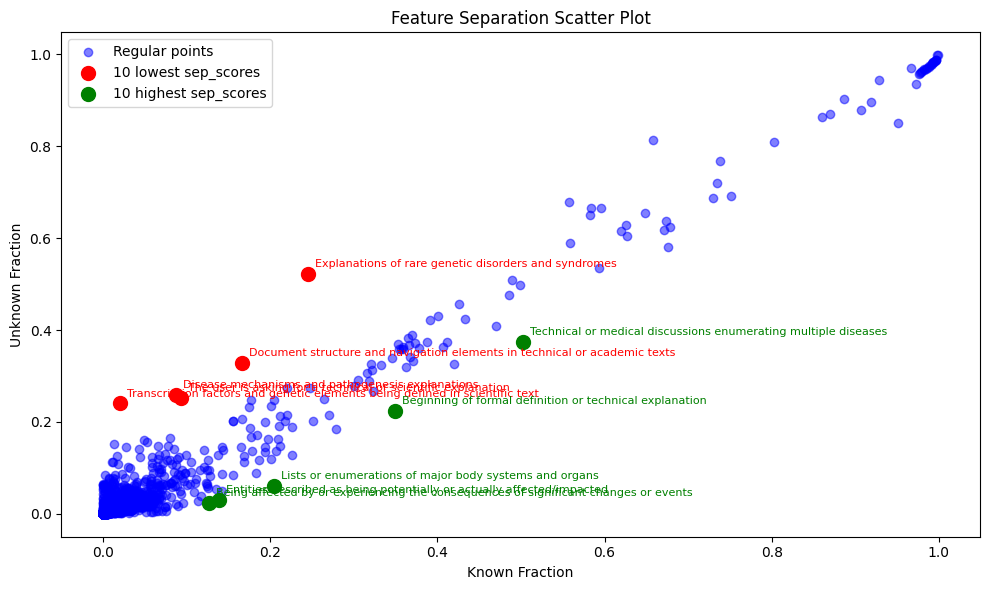

In [41]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Plot all points in blue
plt.scatter(feature_separations['known_frac'], 
           feature_separations['unknown_frac'], 
           alpha=0.5, 
           color='blue', 
           label='Regular points')

# Get indices of top 10 lowest and highest sep_scores
lowest_scores_idx = feature_separations['sep_score'].nsmallest(5).index
highest_scores_idx = feature_separations['sep_score'].nlargest(5).index

# Highlight lowest scores in red
plt.scatter(feature_separations.loc[lowest_scores_idx, 'known_frac'],
           feature_separations.loc[lowest_scores_idx, 'unknown_frac'],
           color='red',
           s=100,
           label='10 lowest sep_scores')

# Highlight highest scores in green
plt.scatter(feature_separations.loc[highest_scores_idx, 'known_frac'],
           feature_separations.loc[highest_scores_idx, 'unknown_frac'],
           color='green',
           s=100,
           label='10 highest sep_scores')

plt.xlabel('Known Fraction')
plt.ylabel('Unknown Fraction')
plt.title('Feature Separation Scatter Plot')
plt.legend()

# Add label annotations for both sets of highlighted points
for idx in lowest_scores_idx:

    plt.annotate(feature_separations.loc[idx, 'label'],
                (feature_separations.loc[idx, 'known_frac'],
                 feature_separations.loc[idx, 'unknown_frac']),
                xytext=(5, 5), textcoords='offset points',
                color='red', fontsize=8)

for idx in highest_scores_idx:
    plt.annotate(feature_separations.loc[idx, 'label'],
                (feature_separations.loc[idx, 'known_frac'],
                 feature_separations.loc[idx, 'unknown_frac']),
                xytext=(5, 5), textcoords='offset points',
                color='green', fontsize=8)

plt.tight_layout()
plt.show()